In [2]:
import pandas as pd
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from tqdm import tqdm
import time
from label_map import id2label  # Label 정보 매핑용 사전, label.py의 내용을 불러 옴
import matplotlib.pyplot as plt

c:\Users\user\anaconda3\envs\test-0602\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [90]:
# 전체 컬럼 내용 출력 제한 해제
pd.set_option("display.max_colwidth", None)

In [6]:
df = pd.read_csv('../../db/news_2023_2025_raw.csv', encoding='utf-8')
df.head(1)

,news_id,wdate,title,article,press,url,image
0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14087 entries, 0 to 14086
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   news_id  14087 non-null  object
 1   wdate    14087 non-null  object
 2   title    14087 non-null  object
 3   article  14087 non-null  object
 4   press    14087 non-null  object
 5   url      14087 non-null  object
 6   image    14087 non-null  object
dtypes: object(7)
memory usage: 770.5+ KB


In [82]:
df_external = pd.read_csv(
    "../../db/news_2023_2025_external.csv"
)
df_external.head(2)

,news_id,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,...,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate
0,20250523_0116,382500.0,119157.0,2.087781e+10,-5.914704e+09,-1.503233e+10,370500.0,111417.0,-8.428448e+09,1.823149e+09,...,-4.547154e+09,2.293918e+09,382500.0,381000.0,383000.0,377500.0,369000.0,1387.1,2.336,2.75
1,20250523_0111,16280.0,29016.0,-3.954377e+07,-7.738182e+07,1.156006e+08,15950.0,47354.0,4.880143e+07,-1.329847e+08,...,2.754089e+08,-2.245507e+08,16960.0,17990.0,17970.0,17790.0,17480.0,1387.1,2.336,2.75


In [83]:
df_external.columns

Index(['news_id', 'd_minus_5_date_close', 'd_minus_5_date_volume',
       'd_minus_5_date_foreign', 'd_minus_5_date_institution',
       'd_minus_5_date_individual', 'd_minus_4_date_close',
       'd_minus_4_date_volume', 'd_minus_4_date_foreign',
       'd_minus_4_date_institution', 'd_minus_4_date_individual',
       'd_minus_3_date_close', 'd_minus_3_date_volume',
       'd_minus_3_date_foreign', 'd_minus_3_date_institution',
       'd_minus_3_date_individual', 'd_minus_2_date_close',
       'd_minus_2_date_volume', 'd_minus_2_date_foreign',
       'd_minus_2_date_institution', 'd_minus_2_date_individual',
       'd_minus_1_date_close', 'd_minus_1_date_volume',
       'd_minus_1_date_foreign', 'd_minus_1_date_institution',
       'd_minus_1_date_individual', 'd_plus_1_date_close',
       'd_plus_2_date_close', 'd_plus_3_date_close', 'd_plus_4_date_close',
       'd_plus_5_date_close', 'fx', 'bond10y', 'base_rate'],
      dtype='object')

In [84]:
import numpy as np

# 기준 컬럼들
prefixes = ["close", "volume", "institution", "foreign", "individual"]
days = ["d_minus_5", "d_minus_4", "d_minus_3", "d_minus_2"]

# 등락률 계산
for prefix in prefixes:
    d_minus_1_col = f"d_minus_1_date_{prefix}"
    for day in days:
        col = f"{day}_date_{prefix}"
        df_external[col] = np.round(
            (df_external[d_minus_1_col] - df_external[col])
            / df_external[d_minus_1_col],
            2,
        )

In [85]:
# 대상 컬럼들
days = [
    "d_plus_5_date_close",
    "d_plus_4_date_close",
    "d_plus_3_date_close",
    "d_plus_2_date_close",
    "d_plus_1_date_close",
]

# 각 컬럼에 대해 D일 대비 등락률(%) 계산
for col in days:
    df_external[col] = np.round(
        (df_external["d_minus_1_date_close"] - df_external[col])
        / df_external["d_minus_1_date_close"],
        2,
    )

In [86]:
df_external.head(1)

,news_id,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,...,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate
0,20250523_0116,-0.01,-0.06,-10.64,-0.3,7.55,0.02,0.01,5.7,1.4,...,-4.547154e+09,2.293918e+09,-0.01,-0.0,-0.01,0.01,0.03,1387.1,2.336,2.75


In [87]:
df_external['d_minus_1_date_close'] = 0
df_external["d_minus_1_date_volume"] = 0
df_external["d_minus_1_date_foreign"] = 0
df_external["d_minus_1_date_institution"] = 0
df_external["d_minus_1_date_individual"] = 0

In [88]:
df_external.head(1)

,news_id,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,...,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate
0,20250523_0116,-0.01,-0.06,-10.64,-0.3,7.55,0.02,0.01,5.7,1.4,...,0,0,-0.01,-0.0,-0.01,0.01,0.03,1387.1,2.336,2.75


In [89]:
cols = [
    "d_minus_5_date_close",
    "d_minus_4_date_close",
    "d_minus_3_date_close",
    "d_minus_2_date_close",
    "d_minus_1_date_close",
    "d_plus_1_date_close",
    "d_plus_2_date_close",
    "d_plus_3_date_close",
    "d_plus_4_date_close",
    "d_plus_5_date_close",
]

df_external["impact_score"] = abs(df_external[cols].max(
    axis=1
) - df_external[cols].min(axis=1))

In [92]:
pd.set_option("display.max_columns", None)  # 모든 컬럼 출력 설정

In [93]:
df_external.head(3)

,news_id,d_minus_5_date_close,d_minus_5_date_volume,d_minus_5_date_foreign,d_minus_5_date_institution,d_minus_5_date_individual,d_minus_4_date_close,d_minus_4_date_volume,d_minus_4_date_foreign,d_minus_4_date_institution,d_minus_4_date_individual,d_minus_3_date_close,d_minus_3_date_volume,d_minus_3_date_foreign,d_minus_3_date_institution,d_minus_3_date_individual,d_minus_2_date_close,d_minus_2_date_volume,d_minus_2_date_foreign,d_minus_2_date_institution,d_minus_2_date_individual,d_minus_1_date_close,d_minus_1_date_volume,d_minus_1_date_foreign,d_minus_1_date_institution,d_minus_1_date_individual,d_plus_1_date_close,d_plus_2_date_close,d_plus_3_date_close,d_plus_4_date_close,d_plus_5_date_close,fx,bond10y,base_rate,impact_score
0,20250523_0116,-0.01,-0.06,-10.64,-0.30,7.55,0.02,0.01,5.70,1.40,-1.42,0.00,0.14,-4.14,0.86,4.79,-0.02,-0.03,-4.79,1.19,5.98,0,0,0,0,0,-0.01,-0.00,-0.01,0.01,0.03,1387.1,2.336,2.75,0.05
1,20250523_0111,-0.03,0.61,0.41,1.28,1.51,-0.01,0.37,1.72,1.48,1.41,-0.03,0.53,3.88,1.44,0.75,-0.01,0.62,0.79,1.32,1.45,0,0,0,0,0,-0.07,-0.14,-0.13,-0.12,-0.10,1387.1,2.336,2.75,0.14
2,20250523_0109,0.07,0.87,1.08,1.08,2.10,0.05,0.67,0.84,0.57,35.01,0.05,0.77,0.58,0.64,-3.24,-0.02,0.10,2.48,-0.26,281.40,0,0,0,0,0,0.03,0.05,0.05,0.05,0.04,1387.1,2.336,2.75,0.09


In [94]:
df_external.to_csv(
    "../../db/news_2023_2025_external.csv",
    index=False,
)

In [63]:
import seaborn as sns

<Axes: xlabel='impact_score', ylabel='Density'>

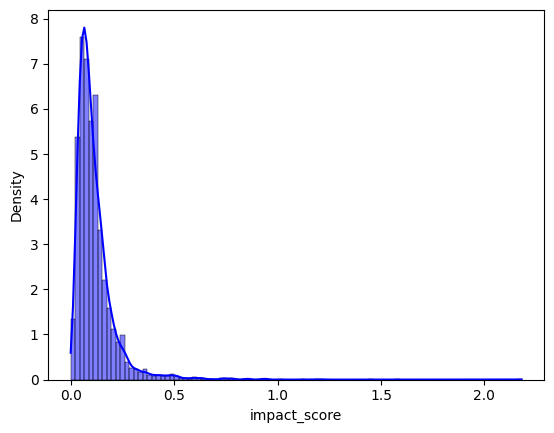

In [64]:
sns.histplot(
    df_external["impact_score"],
    bins=100,
    kde=True,
    color="blue",
    stat="density",
)

In [65]:
df_meta = pd.read_csv(
    "../../db/news_2023_2025_metadata.csv",
)

In [66]:
df_meta.head(1)

,news_id,summary,stock_list,industry_list,impact_score
0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[""카카오페이""]","[""금융 지원 서비스업""]",NaN


In [68]:
df_meta = df_meta.merge(
    df_external[["news_id", "impact_score"]],
    on="news_id",
    how="left",  # df 기준으로 유지, 매칭 안 되면 NaN
)

In [69]:
df_meta.head(1)

,news_id,summary,stock_list,industry_list,impact_score
0,20250523_0002,23일 정보기술(IT)·투자은행(IB) 업계에 따르면 국내 대표 전자결제사업자인 카...,"[""카카오페이""]","[""금융 지원 서비스업""]",0.33


In [70]:
df_meta.to_csv(
    "../../db/news_2023_2025_metadata.csv",
    index=False,
)

In [103]:
df_test = pd.read_csv(
    "../../db/news_2023_2025_metadata.csv",
)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14087 entries, 0 to 14086
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   news_id        14087 non-null  object 
 1   summary        14087 non-null  object 
 2   stock_list     14087 non-null  object 
 3   industry_list  14087 non-null  object 
 4   impact_score   13749 non-null  float64
dtypes: float64(1), object(4)
memory usage: 550.4+ KB


In [102]:
df_test.head(10)

,news_id,wdate,title,article,press,url,image
0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = 연합뉴스]\n국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰다. 네이버페이·토스페이에 대항해 시장 점유율을 늘리려는 포석으로 해석된다.\n23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를 위해 신세계이마트 측과 협상을 진행 중인 것으로 파악됐다. 업계에서는 매각가가 5000억원 안팎에 달할 것으로 전망했다.\n카카오페이는 약 2500만명의 이용자를 보유한 쓱페이·스마일페이를 인수할 경우 사업 외연을 확대할 수 있다.\n매각 작업에 정통한 업계 고위 관계자는 “카카오페이가 결제시장 내 입지 강화를 위해 신세계이마트와 결제사업 부문 인수 등 다양한 방안에 대해 논의 중인 것으로 안다”고 전했다.\n신세계이마트 측은 “매각을 재추진중인 건 맞지만 아직 정해진 것은 없다”고 밝혔다. 신세계이마트는 지난 해 토스와 결제사업 매각을 논의하다 결렬된 바 있다.,매일경제,https://n.news.naver.com/mnews/article/009/0005497731,https://imgnews.pstatic.net/image/009/2025/05/23/0005497731_001_20250523185208038.jpg?type=w800
1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다","[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자(COO)인 존 월드론이 방한해 이창용 한국은행 총재, 이재용 삼성전자 회장, 김병주 MBK파트너스 회장 등과 각각 회동했다. 한국의 금융당국, 기업 및 금융계와의 협력 방안을 논의한 것으로 풀이된다.\n23일 투자은행 업계에 따르면, 월드론 COO는 이날 서울에서 이 총재, 이 회장, 김 회장, 김 대표 등을 잇따라 만나 의견을 교환한 것으로 전해졌다.\n월드론 COO는 현재 글로벌 금융업계에서 차기 골드만삭스 최고경영자(CEO)로 유력시되는 인물이다. 그는 올해 2월 골드만삭스 이사회에 합류하며, 현 CEO 데이비드 솔로몬에 이어 두 번째로 이사회에 입성한 경영위원회 멤버가 됐다. 시장에서는 이를 차기 CEO로의 신호탄으로 해석하고 있다. 월드론은 2000년 골드만삭스에 입사해 2014년 투자은행 부문 공동대표를 거쳤으며, 2018년 10월부터 사장 겸 COO로 재직 중이다.\n골드만삭스는 최근 한국의 정치 상황과 시장 동향을 면밀히 주시하고 있다. 지난해 말에는 계엄령과 탄핵 논의 등으로 정치적 불확실성이 확대되면서, 한국 경제의 하방 리스크가 커졌다는 우려를 나타낸 바 있다.\n또한 최근 보고서에서는 삼성전자의 ‘매수’ 등급을 유지하며, 고대역폭메모리(HBM)를 포함한 D램과 낸드플래시 수요가 개선되고 있으며 범용 메모리반도체의 평균판매가격(ASP)도 회복세에 있다는 점을 강조했다.\n이처럼 복잡한 시점에서 이 총재와 별도 회동을 가진 것은, 월드론 COO가 대선 국면에서의 한국 경제와 금융 시장의 흐름, 금리 정책과 물가 및 성장률, 환율 전망 등을 심도 있게 논의했을 가능성이 크다.",매일경제,https://n.news.naver.com/mnews/article/009/0005497729,https://imgnews.pstatic.net/image/009/2025/05/23/0005497729_001_20250523183307829.png?type=w800
2,20250523_0007,2025-05-23 18:00:00,[단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진,"국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰다. 네이버페이·토스페이에 대항해 시장 점유율을 늘리려는 포석으로 해석된다. 23일 정보기술(IT)·투자은행(IB) 업계에 따르면 카카오페이가 SSG닷컴 쓱페이와 G마켓 스마일페이 인수를 위해 신세계이마트 측과 협상을 진행 중인 것으로 파악됐다. 업계에서는 매각가가 5000억원 안팎에 달할 것으로 전망했다.\n카카오페이는 약 2500만명의 이용자를 보유한 쓱페이·스마일페이를 인수할 경우 사업 외연을 확대할 수 있다. 매각 작업에 정통한 업계 고위 관계자는 ""카카오페이가 결제 시장 내 입지 강화를 위해 신세계이마트와 결제사업 부문 인수 등 다양한 방안에 대해 논의 중인 것으로 안다""고 전했다.\n신세계이마트 측은 ""여러 가능성을 두고 검토 중이나 확정된 바 없다""고 밝혔다. 신세계이마트는 지난해 토스와 결제사업 매각을 논의하다 결렬된 바 있다. 2018년 28조원이던 국내 전자금융업자의 연간 간편결제 규모는 지난해 176조원까지 증가했다. 빅3인 네이버페이, 카카오페이, 토스페이가 90%의 점유율을 기록하고 있다.\n[나현준 기자 / 박나은 기자 / 박홍주 기자]",매일경제,https://n.news.naver.com/mnews/article/009/0005497721,https://ssl.pstatic.net/static.news/image/news/ogtag/navernews_800x420_20221201.jpg
3,20250523_0010,2025-05-23 17:52:00,조현준 효성重 지분 4.9% 美 테크펀드 2600억 매각,"조현준 효성 회장이 상속세 재원 마련을 위해 효성중공업 지분 4.90%를 미국의 글로벌 테크 펀드에 매각했다. 효성중공업은 조 회장이 상속세 재원을 마련하기 위해 시간 외 매매로 효성중공업 주식 45만6903주를 매도했다고 23일 공시했다. 매각 단가는 56만8100원이며, 거래 규모는 약 2596억원이다.\n이번 지분 매각으로 조 회장의 효성중공업 지분율은 14.89%에서 9.99%로 낮아졌다. 효성중공업 최대주주는 효성(주)(지분율 32.47%)이다.\n조 회장의 지분을 매입한 곳은 미국의 톱티어 장기 투자사(테크 펀드)로 알려졌다. 해당 펀드는 효성중공업의 미래 가치를 높게 평가해 투자를 진행한 것으로 전해졌다.\n효성 측은 ""해당 펀드와 협력 관계 구축을 목적으로 협의를 진행해 왔다""고 말했다.\n[한재범 기자]",매일경제,https://n.news.naver.com/mnews/article/009/0005497676,https://ssl.pstatic.net/static.news/image/news/ogtag/navernews_800x420_20221201.jpg
4,20250523_0011,2025-05-23 17:52:00,몸집 키우는 카카오…'간편결제 빅3' 흔드나,"카카오페이, 신세계 페이 품나\n이커머스 결제 강화 점유 확대\n압도적 1위 네이버에 도전장\n매각가 5천억원 안팎 달할 듯\n카카오페이가 신세계 이마트 측에서 쓱페이·스마일페이 인수를 추진하고 나선 건 국내 간편결제 시장에서 영향력을 확대하기 위한 차원이다.\n미리 계좌·카드를 등록만 해놓으면 간편하게 물건·서비스를 결제할 수 있는 간편결제 시장은 해마다 가파른 성장세를 보이며 전자금융 업계의 중요한 먹거리로 급부상 중이다.\n23일 한국은행 등에 따르면 국내 간편지급(간편결제) 서비스 시장의 일평균 이용 금액은 지난해 기준 9594억원에 달한다. 이 중 네이버페이, 카카오페이, 토스페이 등 전자금융업자가 일평균 4814억원, 휴대폰 제조 회사(삼성페이·애플페이 등)가 일평균 2443억원, 금융회사(카드사·은행 등)가 일평균 2337억원을 담당하고 있다. 전자금융업자가 간편지급 시장의 50.7%를 차지하고 있는 셈이다.\n현재 전자금융업자는 총 40개에 달하는데, 이 중 빅3인 네이버페이, 카카오페이, 토스페이가 90%의 점유율을 기록 중이다. 이 밖에 쓱페이, 당근페이, 무신사페이, 컬리페이 등도 경쟁을 펼치고 있다.\n전자금융업자 빅3의 지난해 매출 순위를 보면 네이버페이(네이버파이낸셜) 1조6473억원,

<Axes: xlabel='impact_score_scaled', ylabel='Density'>

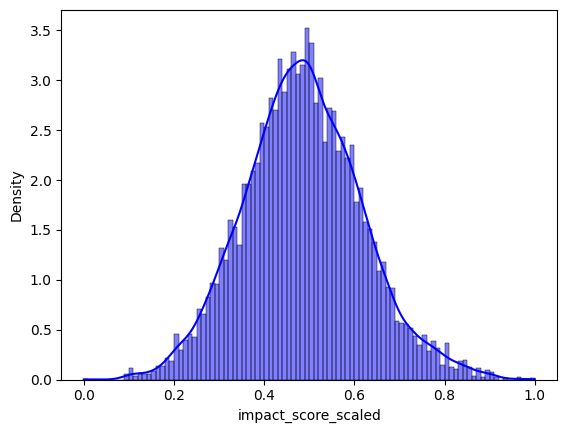

In [92]:
sns.histplot(
    df_external["impact_score_scaled"],
    bins=100,
    kde=True,
    color="blue",
    stat="density",
)

In [91]:
df_external_close['impact_score_scaled'].describe()

count    13459.000000
mean         0.486904
std          0.131146
min          0.000000
25%          0.399848
50%          0.484298
75%          0.571492
max          1.000000
Name: impact_score_scaled, dtype: float64

In [4]:
# NER 모델 및 토크나이저 불러오기
model_name = "KPF/KPF-BERT-NER"
ner_pipeline = pipeline(
    task="ner",
    model=model_name,
    tokenizer=model_name,
    aggregation_strategy="simple",
    framework="pt",
)

Device set to use cpu


In [5]:
# 종목명 사전 불러오기
import pandas as pd
company_df = pd.read_csv("../../db/KRX_KOSPI.csv", encoding="cp949")
company_names = set(company_df["종목명"].dropna().unique())

In [6]:
company_df[company_df["종목명"] == "스틱인베스트먼트"]

,종목코드,종목명,종가,대비,등락률,상장시가총액
358,26890,스틱인베스트먼트,10760,220,2.09,448457.0


In [7]:
# 뉴스 데이터 불러오기 및 제목 + 본문 결합
df["text_combined"] = (
    (df["title"].fillna("") + " " + df["article"].fillna(""))
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

In [8]:
df.head(1)

,wdate,title,article,press,url,image,text_combined
0,2023-05-23 22:25:00,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사",NH투자증권은 23일 충남 당진 문봉리마을 찾아 일손돕기 봉사활동을 진행했다. 정영...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사 NH투자증권은 23일 충남 당진 ..."


In [9]:
# 텍스트 자르기
def split_text(text, max_length=500):
    return [text[i : i + max_length] for i in range(0, len(text), max_length)]

In [10]:
# WordPiece 병합 + 라벨 기반 종목 추출
def extract_stock_labels_by_label_id(text):
    chunks = split_text(text, max_length=500)
    matched_names = set()

    for chunk in chunks:
        entities = ner_pipeline(chunk)

        # WordPiece 병합 처리
        merged_entities = []
        current_word = ""
        current_score = []
        current_label = ""
        for ent in entities:
            word = ent["word"]
            score = ent["score"]
            label_id = ent["entity_group"]
            label_num = int(label_id.split("_")[1])
            label_name = id2label.get(label_num, "")
            key = label_name[2:] if label_name.startswith(("B-", "I-")) else label_name

            # 경제 조직 라벨로 제한 (OGG_ECONOMY 포함)
            if key.startswith("OGG_ECONOMY"):
                if word.startswith("##"):
                    current_word += word[2:]
                    current_score.append(score)
                else:
                    if current_word:
                        merged_entities.append(
                            (
                                current_word,
                                current_label,
                                sum(current_score) / len(current_score),
                            )
                        )
                    current_word = word
                    current_score = [score]
                    current_label = label_name
        if current_word:
            merged_entities.append(
                (current_word, current_label, sum(current_score) / len(current_score))
            )

        for word, label, score in merged_entities:
            if word in company_names:
                matched_names.add(word)

    return list(matched_names)

In [11]:
# 전체 뉴스에 NER 적용

results = []
start_time = time.time()

progress = tqdm(
    enumerate(df["text_combined"]),
    total=len(df),
    desc="전체 뉴스 종목명 라벨링 중",
)

for idx, text in progress:
    try:
        matched = extract_stock_labels_by_label_id(text)
    except Exception as e:
        print(f"오류 (인덱스 {idx}): {e}")
        matched = []
    results.append(matched)

    # 평균 시간 및 남은 시간 계산
    elapsed = time.time() - start_time
    avg_time = elapsed / (idx + 1)
    remaining = avg_time * (len(df) - idx - 1)

    # 진행률 바에 부가 정보 추가
    progress.set_postfix(
        {
            "진행": f"{idx+1}/{len(df)}",
            "평균": f"{avg_time:.2f}s",
            "남은시간": f"{remaining:.1f}s",
        }
    )

df["labels_by_id"] = results

전체 뉴스 종목명 라벨링 중:   0%|          | 0/89609 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
전체 뉴스 종목명 라벨링 중: 100%|██████████| 89609/89609 [8:28:55<00:00,  2.93it/s, 진행=89609/89609, 평균=0.34s, 남은시간=0.0s]       


In [12]:
df.to_csv("news_2021_2023_with_NER.csv", index=False)

In [13]:
df.head(3)

,wdate,title,article,press,url,image,text_combined,labels_by_id
0,2023-05-23 22:25:00,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사",NH투자증권은 23일 충남 당진 문봉리마을 찾아 일손돕기 봉사활동을 진행했다. 정영...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사 NH투자증권은 23일 충남 당진 ...",[NH투자증권]
1,2023-05-23 19:03:00,"“자전거래를 해?”···금감원, KB·하나證 검사 돌입",단기투자 상품인 랩·신탁을 장기채 투자\n수익률 높일 목적이었던 것으로 의심\n원본...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"“자전거래를 해?”···금감원, KB·하나證 검사 돌입 단기투자 상품인 랩·신탁을 ...",[]
2,2023-05-23 18:50:00,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종치)",[서울경제]\n23일 코스닥지수는 전일보다 7.12포인트(0.84%) 상승한 859...,서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종...","[포스코DX, CJ, 엘앤에프]"


In [14]:
df_filtered = df[df["labels_by_id"].apply(lambda x: len(x) > 0)]

In [15]:
# 2. label_by_id[0] 값을 stock_name으로 저장
df_filtered["stock_name"] = df_filtered["labels_by_id"].apply(lambda x: x[0] if len(x) > 0 else None)

# 3. company_df를 기준으로 stock_name → stock_id 매핑
df_filtered = df_filtered.merge(company_df, how="left", left_on="stock_name", right_on="종목명")
df_filtered = df_filtered.rename(columns={"id": "stock_id"})

# 4. 종목명 컬럼은 필요 시 제거
df_filtered.drop(columns=["종목명", "종가", "대비", "등락률"], inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_19156\2462263517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["stock_name"] = df_filtered["labels_by_id"].apply(lambda x: x[0] if len(x) > 0 else None)


In [16]:
df_filtered.head(3)

,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,종목코드,상장시가총액
0,2023-05-23 22:25:00,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사",NH투자증권은 23일 충남 당진 문봉리마을 찾아 일손돕기 봉사활동을 진행했다. 정영...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사 NH투자증권은 23일 충남 당진 ...",[NH투자증권],NH투자증권,5940,5367599.0
1,2023-05-23 18:50:00,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종치)",[서울경제]\n23일 코스닥지수는 전일보다 7.12포인트(0.84%) 상승한 859...,서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종...","[포스코DX, CJ, 엘앤에프]",포스코DX,22100,3253543.0
2,2023-05-23 18:32:00,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","[서울경제]\n23일 코스피는 2,567대에서 강보합세로 거래를 마쳤다.\n코스피는...",서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","[크래프톤, SK이노베이션, 포스코인터내셔널, 한올바이오파마, POSCO홀딩스, L...",크래프톤,259960,18544343.0


In [17]:
df_filtered["종목코드"] = df_filtered["종목코드"].astype(str).str.zfill(6)

In [18]:
df_filtered.head(3)

,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,종목코드,상장시가총액
0,2023-05-23 22:25:00,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사",NH투자증권은 23일 충남 당진 문봉리마을 찾아 일손돕기 봉사활동을 진행했다. 정영...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사 NH투자증권은 23일 충남 당진 ...",[NH투자증권],NH투자증권,005940,5367599.0
1,2023-05-23 18:50:00,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종치)",[서울경제]\n23일 코스닥지수는 전일보다 7.12포인트(0.84%) 상승한 859...,서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종...","[포스코DX, CJ, 엘앤에프]",포스코DX,022100,3253543.0
2,2023-05-23 18:32:00,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","[서울경제]\n23일 코스피는 2,567대에서 강보합세로 거래를 마쳤다.\n코스피는...",서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","[크래프톤, SK이노베이션, 포스코인터내셔널, 한올바이오파마, POSCO홀딩스, L...",크래프톤,259960,18544343.0


In [26]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52828 entries, 0 to 52827
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wdate          52828 non-null  datetime64[ns]
 1   title          52828 non-null  object        
 2   article        52820 non-null  object        
 3   press          52828 non-null  object        
 4   url            52828 non-null  object        
 5   image          52824 non-null  object        
 6   text_combined  52828 non-null  object        
 7   labels_by_id   52828 non-null  object        
 8   stock_name     52828 non-null  object        
 9   종목코드           52828 non-null  object        
 10  상장시가총액         52828 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 4.4+ MB


In [19]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pykrx.stock import get_market_ohlcv_by_date

# ✅ 등락률 구간 설정
delta_days = [-30, -14, -7, -3, -2, -1, 0, 1, 2, 3, 7, 14, 30]


def get_price_and_returns(code: str, base_date: pd.Timestamp):
    """
    주어진 종목코드(code)와 기준일(base_date)을 기준으로
    기준일 종가와 D±N일 등락률 반환
    """
    start = (base_date + timedelta(days=min(delta_days) - 5)).strftime("%Y%m%d")
    end = (base_date + timedelta(days=max(delta_days) + 5)).strftime("%Y%m%d")

    try:
        df_price = get_market_ohlcv_by_date(start, end, code)
    except:
        return None  # 종목코드 오류 시

    df_price.index = pd.to_datetime(df_price.index)

    # base_price 찾기
    try:
        base_actual = df_price.index[
            df_price.index.get_indexer([base_date], method="nearest")[0]
        ]
        base_price = df_price.loc[base_actual, "종가"]
    except:
        return None

    result = {"base_price": int(base_price)}

    for d in delta_days:
        if d == 0:
            continue
        target = base_date + timedelta(days=d)
        try:
            actual_target = df_price.index[
                df_price.index.get_indexer([target], method="nearest")[0]
            ]
            target_price = df_price.loc[actual_target, "종가"]
            rate = round(((target_price - base_price) / base_price) * 100, 2)
            result[f"D{d:+d}"] = rate
        except:
            result[f"D{d:+d}"] = np.nan  # 값 없음 처리

    return result

In [20]:
# 날짜 형식 변환
df_filtered["wdate"] = pd.to_datetime(df_filtered["wdate"])

# 결과 저장용
price_data = []

for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered), desc="뉴스별 주가 조회 진행 중"):
    result = get_price_and_returns(row["종목코드"], row["wdate"])
    price_data.append(result if result else {})  # None → 빈 dict

# 컬럼 확장
price_df = pd.DataFrame(price_data)
df_combined = pd.concat([df_filtered, price_df], axis=1)

뉴스별 주가 조회 진행 중: 100%|██████████| 52828/52828 [39:22<00:00, 22.36it/s]


In [21]:
df_combined.head(3)

,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,종목코드,...,D-7,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30
0,2023-05-23 22:25:00,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사",NH투자증권은 23일 충남 당진 문봉리마을 찾아 일손돕기 봉사활동을 진행했다. 정영...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사 NH투자증권은 23일 충남 당진 ...",[NH투자증권],NH투자증권,005940,...,-3.82,-1.03,-1.03,-0.72,-0.41,-0.10,-0.10,3.10,0.41,-2.06
1,2023-05-23 18:50:00,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종치)",[서울경제]\n23일 코스닥지수는 전일보다 7.12포인트(0.84%) 상승한 859...,서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종...","[포스코DX, CJ, 엘앤에프]",포스코DX,022100,...,-3.54,-3.22,-3.22,-0.58,-3.71,-6.02,-6.02,-5.44,4.78,37.35
2,2023-05-23 18:32:00,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","[서울경제]\n23일 코스피는 2,567대에서 강보합세로 거래를 마쳤다.\n코스피는...",서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","[크래프톤, SK이노베이션, 포스코인터내셔널, 한올바이오파마, POSCO홀딩스, L...",크래프톤,259960,...,7.01,7.28,7.28,6.63,0.32,-0.91,-0.91,1.18,3.58,7.81


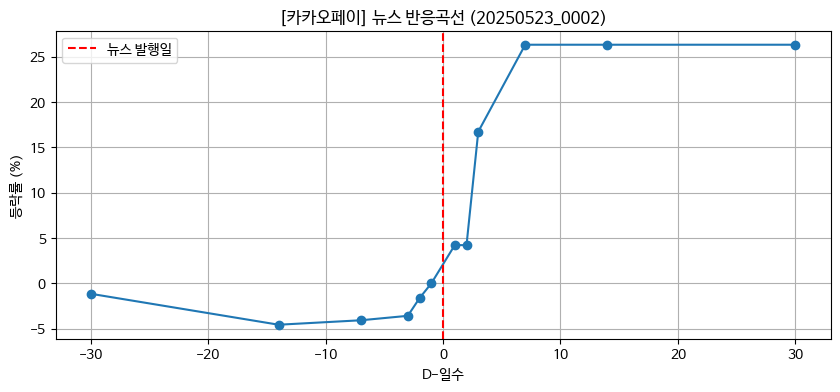

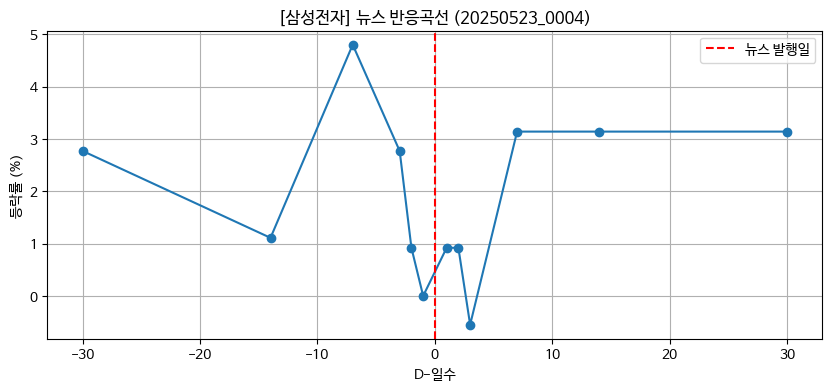

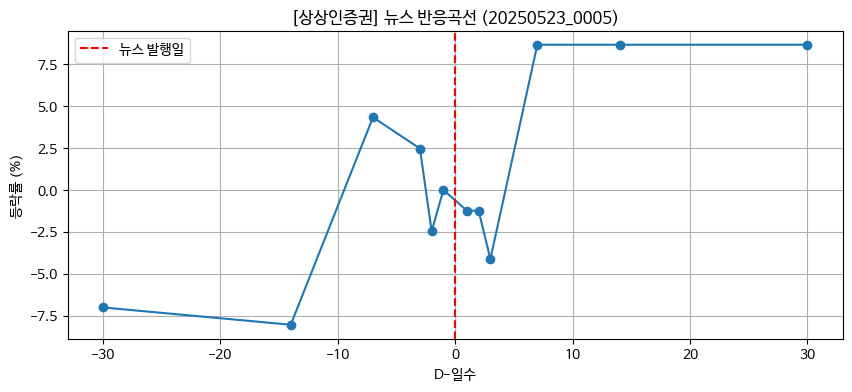

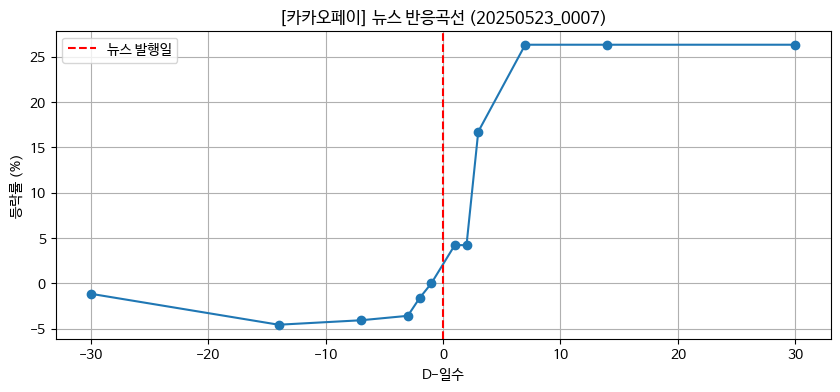

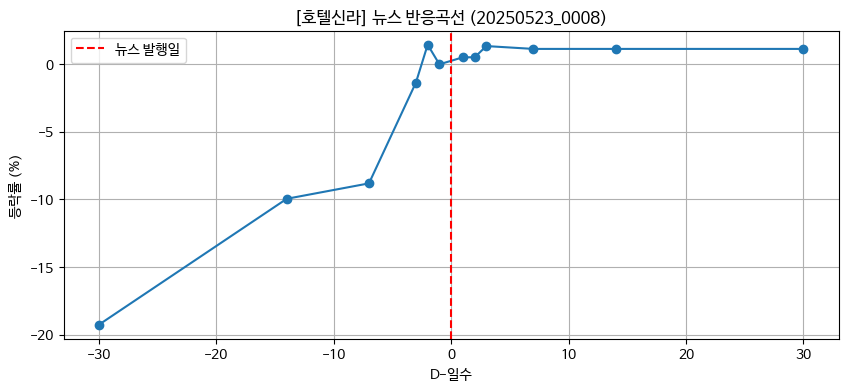

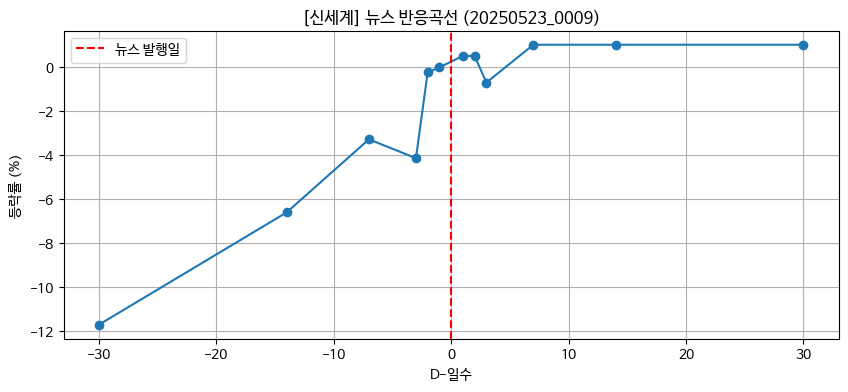

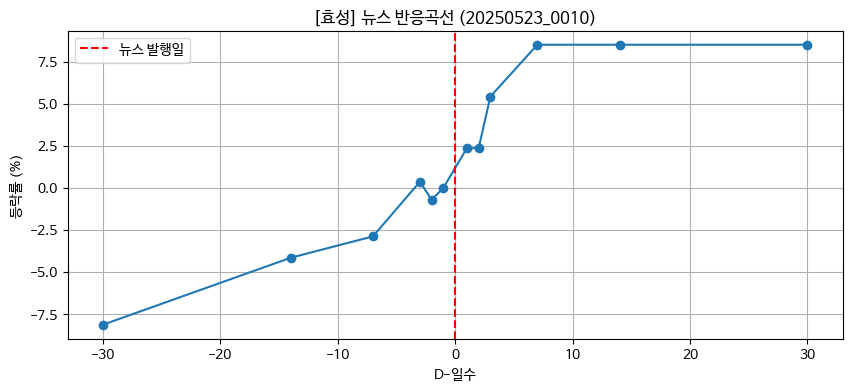

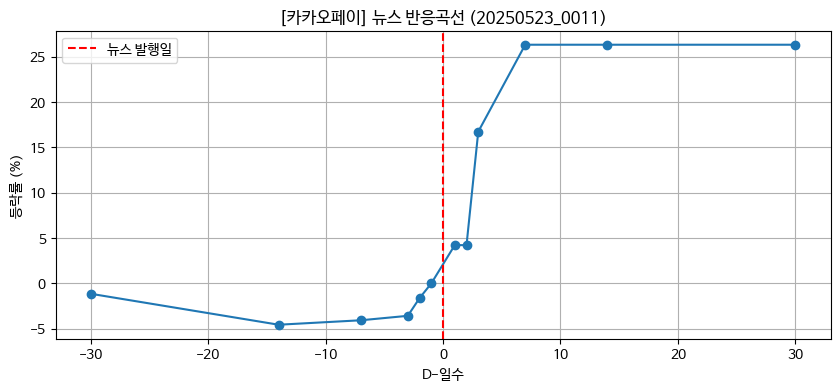

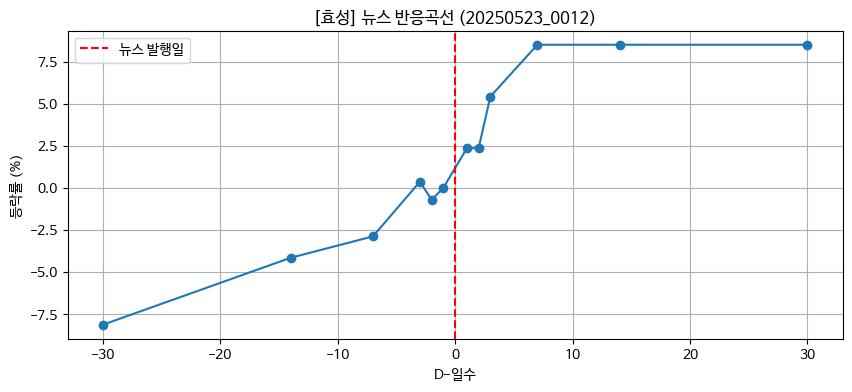

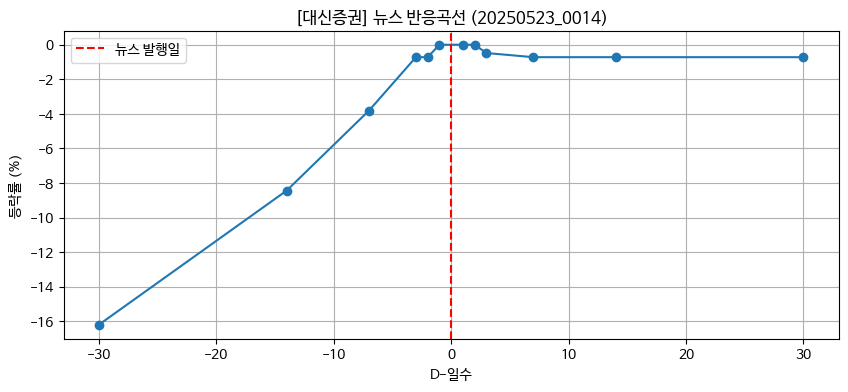

In [78]:
def plot_one_news(row):
    delta_cols = [c for c in row.index if c.startswith("D") and row[c] is not np.nan]
    x = [int(c.replace("D+", "").replace("D-", "-")) for c in delta_cols]
    y = [row[c] for c in delta_cols]

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, marker="o")
    plt.axvline(0, color="red", linestyle="--", label="뉴스 발행일")
    plt.title(f"[{row['stock_name']}] 뉴스 반응곡선 ({row['news_id']})")
    plt.xlabel("D-일수")
    plt.ylabel("등락률 (%)")
    plt.grid(True)
    plt.legend()
    plt.show()


# 사용 예시
for i in range(10):
    plot_one_news(df_combined.iloc[i])

In [22]:
# 등락률 관련 칼럼 추출 (원하면 D+만으로 제한 가능)
delta_cols = ['D-30', 'D-14', 'D-7', 'D-3', 'D-2', 'D-1', 'D+1', 'D+2', 'D+3', 'D+7', 'D+14', 'D+30']

# 최대-최소 진폭 계산
df_combined["impact_score"] = df_combined[delta_cols].max(axis=1) - df_combined[delta_cols].min(axis=1)

In [23]:
df_combined['impact_score'].describe()

count    52261.000000
mean        17.683832
std         17.990286
min          0.000000
25%          9.500000
50%         13.580000
75%         20.630000
max        502.440000
Name: impact_score, dtype: float64

In [24]:
df_combined.to_csv("news_2021_2023_with_stock_impact.csv", index=False)

In [27]:
df_test_1 = pd.read_csv('news_2021_2023_with_NER.csv')
df_test_1.head()

,wdate,title,article,press,url,image,text_combined,labels_by_id
0,2023-05-23 22:25:00,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사",NH투자증권은 23일 충남 당진 문봉리마을 찾아 일손돕기 봉사활동을 진행했다. 정영...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사 NH투자증권은 23일 충남 당진 ...",['NH투자증권']
1,2023-05-23 19:03:00,"“자전거래를 해?”···금감원, KB·하나證 검사 돌입",단기투자 상품인 랩·신탁을 장기채 투자\n수익률 높일 목적이었던 것으로 의심\n원본...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"“자전거래를 해?”···금감원, KB·하나證 검사 돌입 단기투자 상품인 랩·신탁을 ...",[]
2,2023-05-23 18:50:00,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종치)",[서울경제]\n23일 코스닥지수는 전일보다 7.12포인트(0.84%) 상승한 859...,서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종...","['포스코DX', 'CJ', '엘앤에프']"
3,2023-05-23 18:44:00,"'양자역학 AI 신약 개발' 인세리브로, 바이오USA로 해외 공략",양자역학 기반의 AI(인공지능) 신약 개발 기업 인세리브로(대표 조은성)가 오는 6...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://ssl.pstatic.net/static.news/image/news...,"'양자역학 AI 신약 개발' 인세리브로, 바이오USA로 해외 공략 양자역학 기반의 ...",[]
4,2023-05-23 18:32:00,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","[서울경제]\n23일 코스피는 2,567대에서 강보합세로 거래를 마쳤다.\n코스피는...",서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","['크래프톤', 'SK이노베이션', '포스코인터내셔널', '한올바이오파마', 'PO..."


In [28]:
df_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89609 entries, 0 to 89608
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   wdate          89609 non-null  object
 1   title          89609 non-null  object
 2   article        89504 non-null  object
 3   press          89609 non-null  object
 4   url            89609 non-null  object
 5   image          89598 non-null  object
 6   text_combined  89609 non-null  object
 7   labels_by_id   89609 non-null  object
dtypes: object(8)
memory usage: 5.5+ MB


In [29]:
df_test_2 = pd.read_csv('news_2021_2023_with_stock_impact.csv')
df_test_2.head()

,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,종목코드,...,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30,impact_score
0,2023-05-23 22:25:00,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사",NH투자증권은 23일 충남 당진 문봉리마을 찾아 일손돕기 봉사활동을 진행했다. 정영...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"NH 조소행·정영채·윤병운·최승호, 일손돕기 봉사 NH투자증권은 23일 충남 당진 ...",['NH투자증권'],NH투자증권,5940,...,-1.03,-1.03,-0.72,-0.41,-0.10,-0.10,3.10,0.41,-2.06,8.16
1,2023-05-23 18:50:00,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종치)",[서울경제]\n23일 코스닥지수는 전일보다 7.12포인트(0.84%) 상승한 859...,서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시] 엘앤에프, 기관·외국인 코스닥 순매수 1위(5월 23일-최종...","['포스코DX', 'CJ', '엘앤에프']",포스코DX,22100,...,-3.22,-3.22,-0.58,-3.71,-6.02,-6.02,-5.44,4.78,37.35,43.37
2,2023-05-23 18:32:00,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","[서울경제]\n23일 코스피는 2,567대에서 강보합세로 거래를 마쳤다.\n코스피는...",서울경제,https://n.news.naver.com/mnews/article/011/000...,https://imgnews.pstatic.net/image/011/2023/05/...,"[데이터로 보는 증시]삼성전자·LG엔솔, 기관·외국인 코스피 순매수 1위(5월 23...","['크래프톤', 'SK이노베이션', '포스코인터내셔널', '한올바이오파마', 'PO...",크래프톤,259960,...,7.28,7.28,6.63,0.32,-0.91,-0.91,1.18,3.58,7.81,8.72
3,2023-05-23 18:18:00,"넥스턴바이오,반도체 장비 미래산업 245억에 인수 본계약 체결",넥스턴바이오사이언스(이하 넥스턴바이오)는 광림과 코스피 상장사 미래산업의 주식 48...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://ssl.pstatic.net/static.news/image/news...,"넥스턴바이오,반도체 장비 미래산업 245억에 인수 본계약 체결 넥스턴바이오사이언스(...",['미래산업'],미래산업,25560,...,11.24,11.24,4.86,-4.35,-12.20,-12.20,-12.98,-15.05,-1.14,28.18
4,2023-05-23 18:06:00,올해 27% 뛴 ‘필반’ 지수···관련 펀드는 순자산 4000억 돌파,유리필라델피아반도체인덱스 펀드\n사진=유리자산운용 제공\n[파이낸셜뉴스] 반도체주 ...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,올해 27% 뛴 ‘필반’ 지수···관련 펀드는 순자산 4000억 돌파 유리필라델피아...,['삼성전자'],삼성전자,5930,...,0.00,0.00,-0.15,0.44,2.63,2.63,4.23,3.65,4.53,10.22


In [30]:
df_test_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52828 entries, 0 to 52827
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wdate          52828 non-null  object 
 1   title          52828 non-null  object 
 2   article        52820 non-null  object 
 3   press          52828 non-null  object 
 4   url            52828 non-null  object 
 5   image          52824 non-null  object 
 6   text_combined  52828 non-null  object 
 7   labels_by_id   52828 non-null  object 
 8   stock_name     52828 non-null  object 
 9   종목코드           52828 non-null  int64  
 10  상장시가총액         52828 non-null  float64
 11  base_price     52261 non-null  float64
 12  D-30           52261 non-null  float64
 13  D-14           52261 non-null  float64
 14  D-7            52261 non-null  float64
 15  D-3            52261 non-null  float64
 16  D-2            52261 non-null  float64
 17  D-1            52261 non-null  float64
 18  D+1   

In [25]:
df_combined_top_20 = df_combined.sort_values(by="impact_score", ascending=False).head(20)
df_combined_top_20

,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,종목코드,...,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30,impact_score
742,2023-05-15 09:21:00,반대매매 후폭풍…디와이피엔에프 또 급락세,"SG증권, 모건스탠리 창구로 매도 집중\n디와이피엔에프가 개인주주 보유 물량 반대매...",한국경제TV,https://n.news.naver.com/mnews/article/215/000...,https://imgnews.pstatic.net/image/215/2023/05/...,"반대매매 후폭풍…디와이피엔에프 또 급락세 SG증권, 모건스탠리 창구로 매도 집중 디...",[대성홀딩스],대성홀딩스,016710,...,4.79,4.79,0.00,-1.74,-3.49,-5.23,-4.36,-16.64,-28.15,502.44
857,2023-05-12 16:19:00,"코스닥 종목 하한가에…""혹시 또""",12일 코스닥시장에서 디와이피엔에프가 하한가로 추락하면서 'SG증권발 폭락 사태'의...,한국경제TV,https://n.news.naver.com/mnews/article/215/000...,https://imgnews.pstatic.net/image/215/2023/05/...,"코스닥 종목 하한가에…""혹시 또"" 12일 코스닥시장에서 디와이피엔에프가 하한가로 추...","[대성홀딩스, 신대양제지]",대성홀딩스,016710,...,7.28,3.33,0.00,-4.57,-4.57,-6.24,-8.11,-18.30,-29.60,474.30
868,2023-05-12 10:34:00,제2의 SG發 하한가?...'전수조사' 급락세 속출,끝나지 않은 CFD 반대매매…디와이피엔에프 하한가 직행\n12일 디와이피엔에프의 주...,한국경제TV,https://n.news.naver.com/mnews/article/215/000...,https://imgnews.pstatic.net/image/215/2023/05/...,제2의 SG發 하한가?...'전수조사' 급락세 속출 끝나지 않은 CFD 반대매매…디...,"[대성홀딩스, 신대양제지]",대성홀딩스,016710,...,2.29,7.28,3.33,0.00,-4.57,-4.57,-8.11,-18.30,-29.60,468.48
545,2023-05-17 05:01:00,CFD 반대매매 폭락주 줍줍하는 기관들... 회복은 언제?,[파이낸셜뉴스] 차액결제거래(CFD) 반대매매 여파로 하한가를 맞은 종목들이 부진한...,파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,CFD 반대매매 폭락주 줍줍하는 기관들... 회복은 언제? [파이낸셜뉴스] 차액결제...,"[서울가스, 다올투자증권, 삼천리]",서울가스,017390,...,0.44,0.44,0.33,-2.51,-0.87,-0.87,-2.62,-8.52,-20.52,459.82
1178,2023-05-09 18:12:00,"한국거래소 ""제2의 SG증권發 사태 막는다""","장기간 시세조종 적발시스템 강화\n기획감시팀, 하반기내 보안 개선\n한국거래소가 장...",파이낸셜뉴스,https://n.news.naver.com/mnews/article/014/000...,https://imgnews.pstatic.net/image/014/2023/05/...,"한국거래소 ""제2의 SG증권發 사태 막는다"" 장기간 시세조종 적발시스템 강화 기획감...",[대성홀딩스],대성홀딩스,016710,...,0.97,0.97,-4.65,-3.68,-6.78,-6.78,-14.15,-17.64,-32.40,458.76
1088,2023-05-10 11:26:00,"윤창현 ""SG발 폭락사태로 개인 7만여명, 7730억원 피해""","""주주명부 작성일부터 9일까지 해당 주식 보유 가정해 추산""\n윤창현 국민의힘 의원...",한국경제,https://n.news.naver.com/mnews/article/015/000...,https://imgnews.pstatic.net/image/015/2023/05/...,"윤창현 ""SG발 폭락사태로 개인 7만여명, 7730억원 피해"" ""주주명부 작성일부터...","[대성홀딩스, 다올투자증권, 삼천리]",대성홀딩스,016710,...,0.97,0.97,-4.65,-3.68,-6.78,-6.78,-14.15,-17.64,-32.40,458.76
872,2023-05-12 09:44:00,"""에코 급락 여파가 여기까지""…SG發 8종목 약세",SG증권발 폭락 사태를 겪은 8종목의 주가가 좀처럼 반등하지 못하고 있다.\n12일...,한국경제TV,https://n.news.naver.com/mnews/article/215/000...,https://imgnews.pstatic.net/image/215/2023/05/...,"""에코 급락 여파가 여기까지""…SG發 8종목 약세 SG증권발 폭락 사태를 겪은 8종...","[서울가스, 세방, 삼천리, 대성홀딩스, 다올투자증권]",서울가스,017390,...,4.92,6.63,3.21,0.00,-1.60,-1.60,-2.89,-11.66,-17.22,441.28
938,2023-05-11 17:09:00,"손병두 이사장 ""시세조종 혐의 포착 때 '거래패턴' 살필 것""",손병두 한국거래소 이사장이 11일 오후 서울 여의도 국회에서 열린 정무위원회 전체회...,한국경제,https://n.news.naver.com/mnews/article/015/000...,https://imgnews.pstatic.net/image/015/2023/05/...,"손병두 이사장 ""시세조종 혐의 포착 때 '거래패턴' 살필 것"" 손병두 한국거래소 이...","[서울가스, 다올투자증권, 삼천리]",서울가스,017390,...,4.92,6.63,3.21,0.00,-1.60,-1.60,-2.89,-11.66,-17.22,441.28
941,2023-05-11 16:59:00,‘SG발 폭락주’에 뛰어든 개미...증권가도 이 종목은 ‘추천’,원본보기\nSG증권발 주가 폭락사태로 피해를 봤다고 주장하는 투자자들의 법률 대리 ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2023/05/...,‘SG발 폭락주’에 뛰어든 개미...증권가도 이 종목은 ‘추천’ 원본보기 SG증권발...,"[서울가스, 세방, 삼천리, 대성홀딩스, 다올투자증권]",서울가스,017390,...,4.92,6.63,3.21,0.00,-1.60,-1.60,-2.89,-11.66,-17.22,441.28
206,2023-05-22 06:41:00,"[라덕연게이트]CFD 제도 개선 잰걸음, 유사투자자문업 집중 단속","금융위·금감원 SG증권발 폭락 사태 책임론에 진땀\n정치권, 사후 처벌 강화 등 재...",아시아경제,https://n.news.naver.com/mnews/article/277/000...,https://imgnews.pstatic.net/image/277/2023/05/...,"[라덕연게이트]CFD 제도 개선 잰걸음, 유사투자자문업 집중 단속 금융위·금감원 S...",[서울가스],서울가스,017390,...,0.55,0.55,0.00,0.11,-1.22,-4.54,-8.42,-9.52,-23.26,440.98


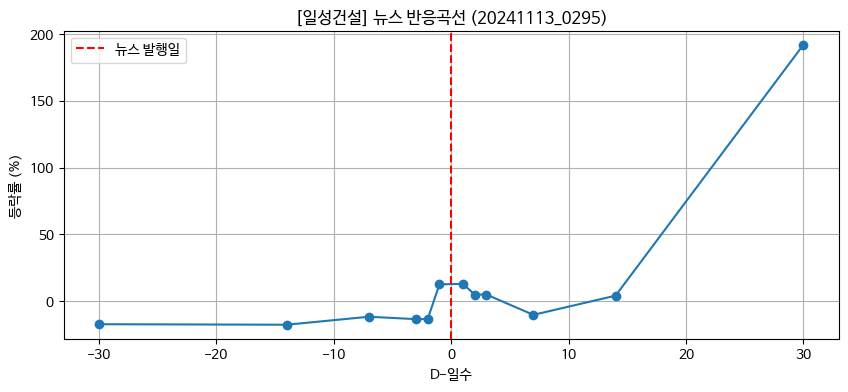

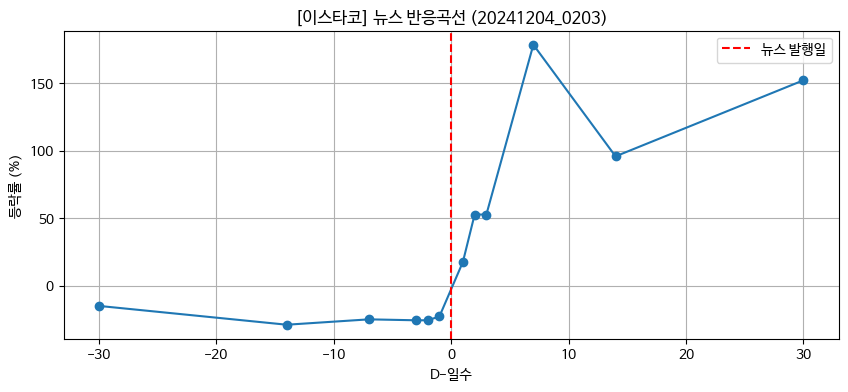

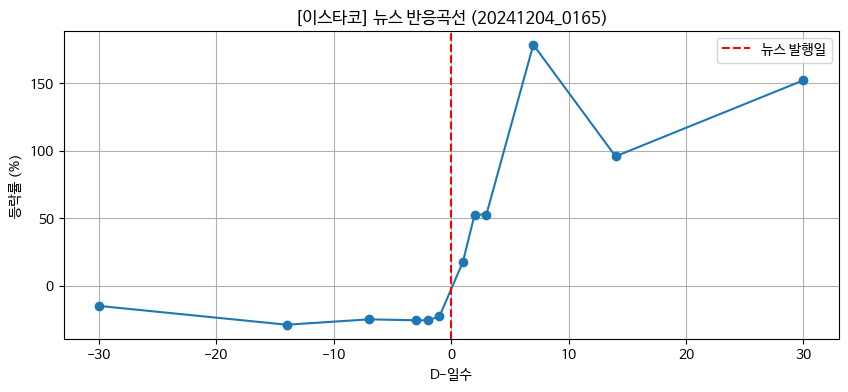

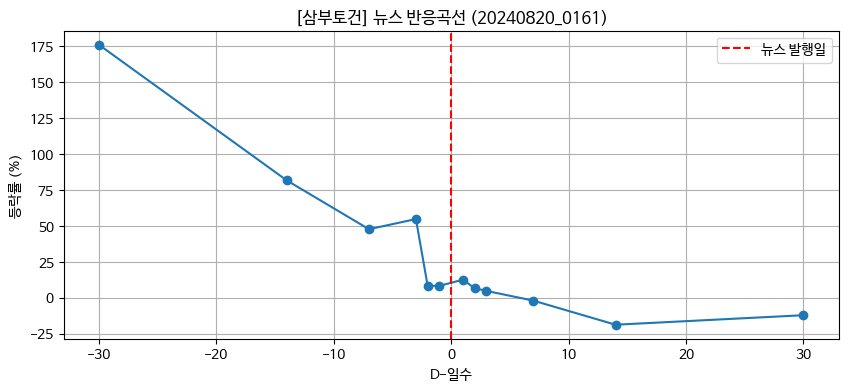

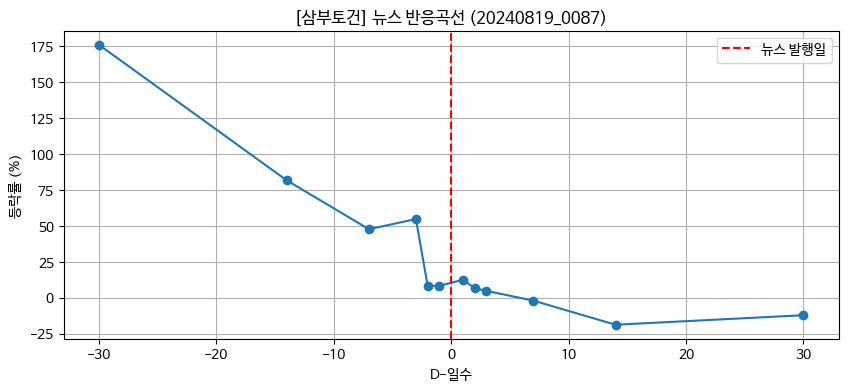

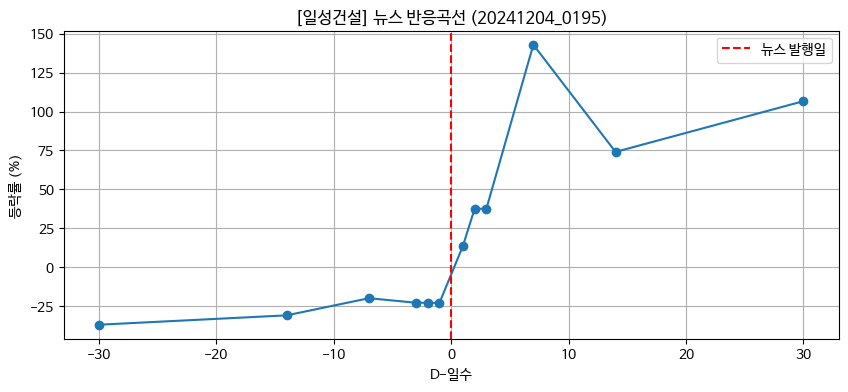

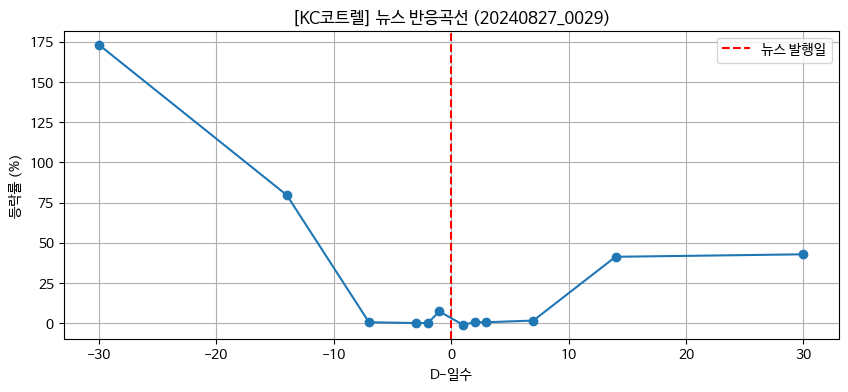

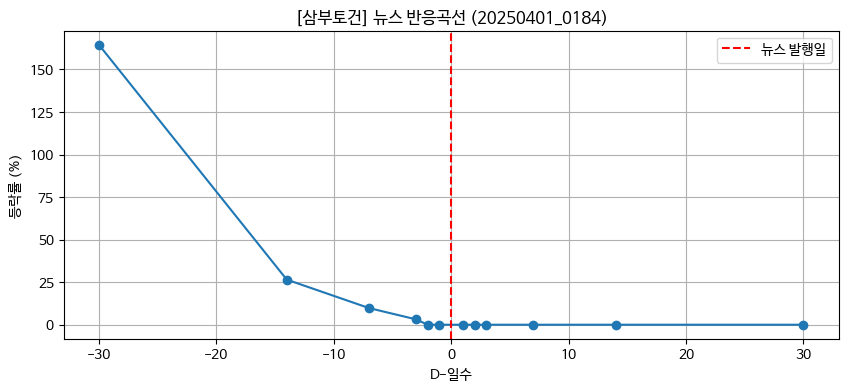

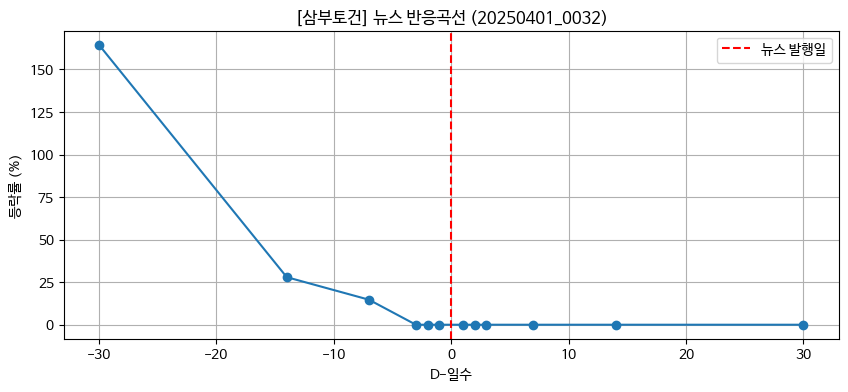

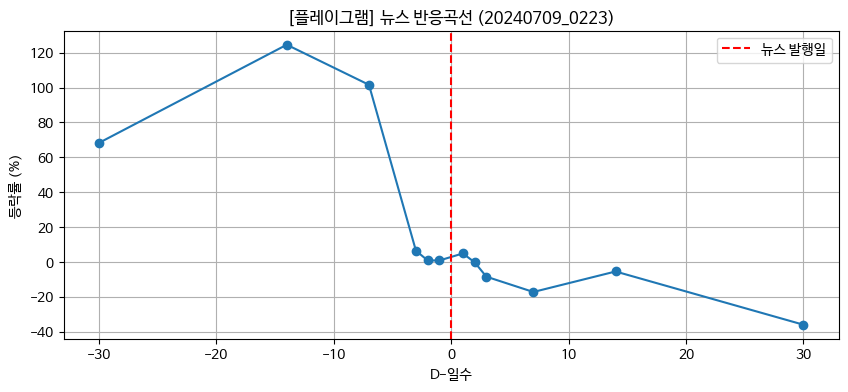

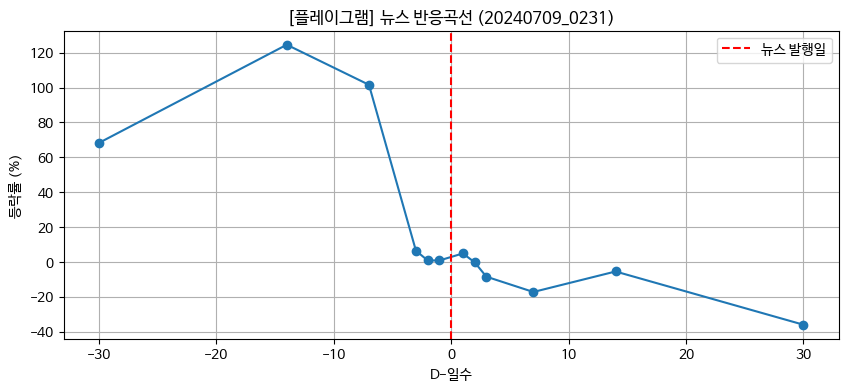

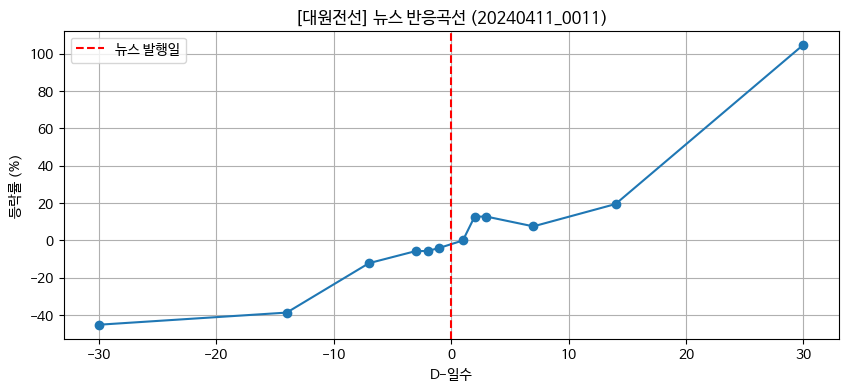

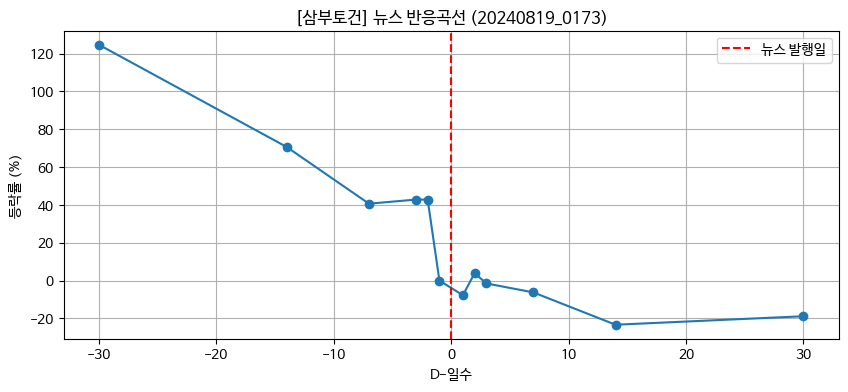

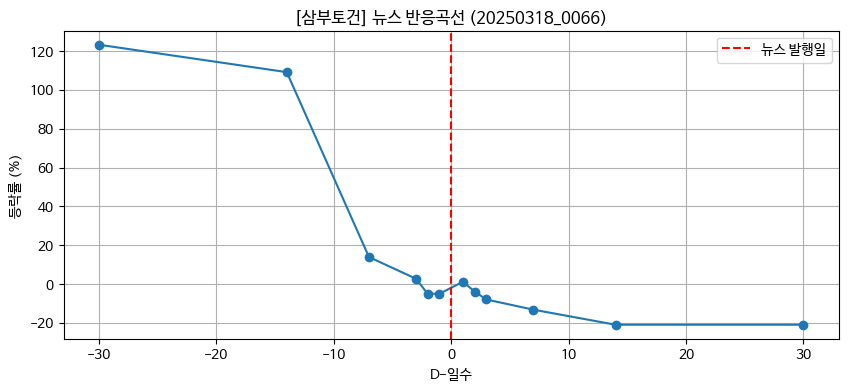

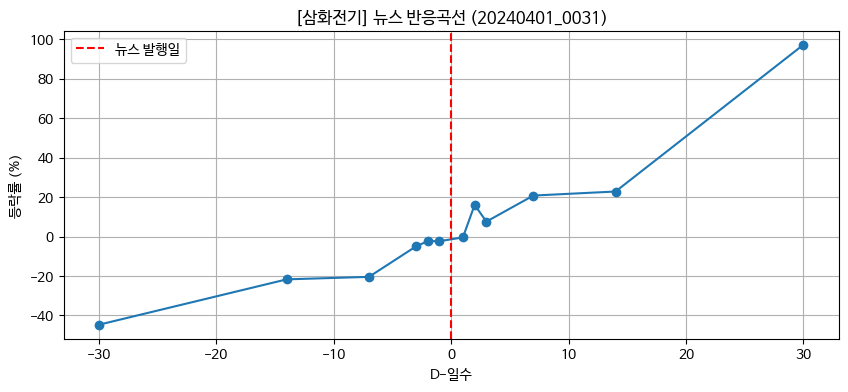

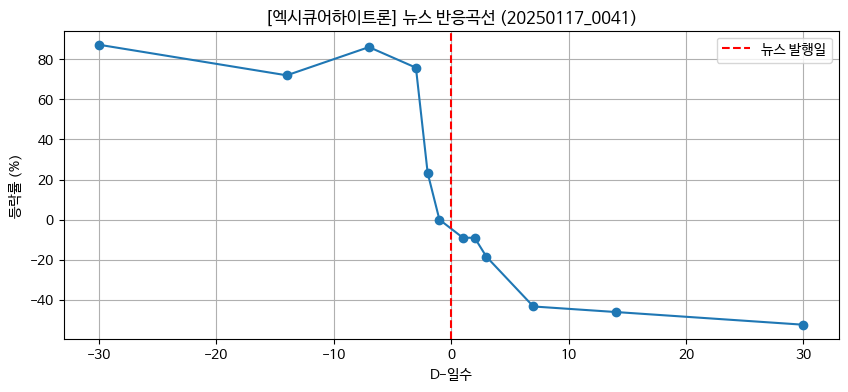

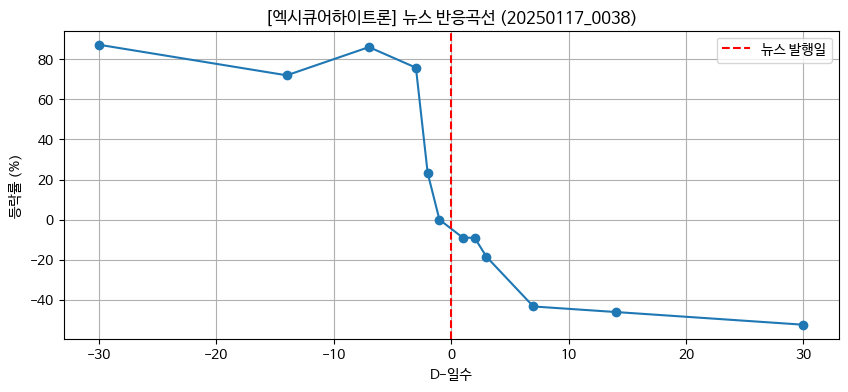

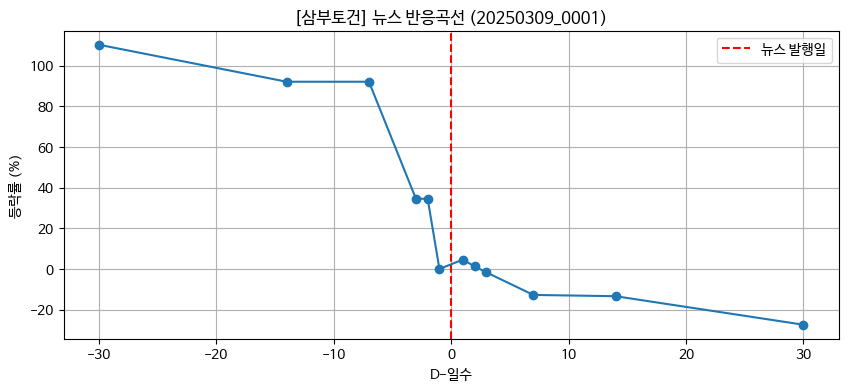

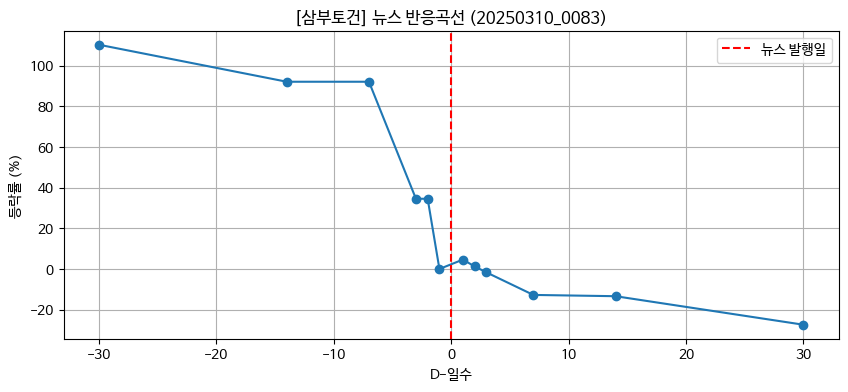

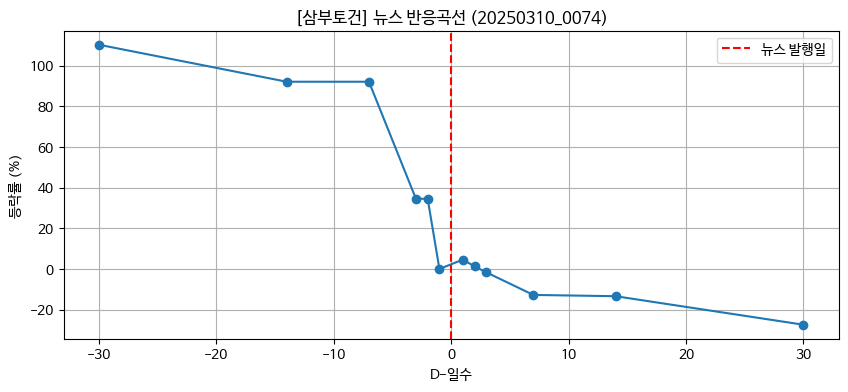

In [104]:
# 사용 예시
for i in range(20):
    plot_one_news(df_combined_top_20.iloc[i])

In [39]:
df_combined_bottom_20 = df_combined.sort_values(by="impact_score", ascending=True)[900:920]
df_combined_bottom_20

,news_id,wdate,title,press,text_combined,labels_by_id,stock_name,종목코드,base_price,D-30,...,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30,impact_score
1144,20250202_0012,2025-02-02 16:38:00,출생아 수 반등에…백화점 유아용품 시장도 성장세,서울경제,출생아 수 반등에…백화점 유아용품 시장도 성장세 출생아 5개월 연속 증가세 신세계百...,[신세계],신세계,004170,129400.0,1.08,...,2.55,2.55,0.00,0.39,0.39,3.71,1.39,7.26,14.91,14.91
520,20241127_0213,2024-11-27 09:06:00,"[클릭 e종목]""두산로보틱스, 그룹 지배구조 개편 최대 수혜""",아시아경제,"[클릭 e종목]""두산로보틱스, 그룹 지배구조 개편 최대 수혜"" DS투자증권은 27일...","[두산밥캣, 두산로보틱스]",두산밥캣,241560,38900.0,-2.70,...,-1.67,-1.67,0.64,-0.13,-0.26,-0.26,8.35,11.05,12.08,14.91
1080,20240130_0206,2024-01-30 09:17:00,"상승기류 올라탄 증시…""대형주, 지수 견인""",한국경제TV,"상승기류 올라탄 증시…""대형주, 지수 견인"" 30일 오전 9시 10분 기준 KOSP...","[LG에너지솔루션, 셀트리온, NAVER, 기아, 삼성바이오로직스, 삼성전자, 현대...",LG에너지솔루션,373220,375000.0,14.53,...,1.60,0.67,0.67,1.60,1.73,3.33,0.53,4.93,7.07,14.93
1148,20250522_0138,2025-05-22 08:28:00,"NH투자 ""'미용기기' 아스테라시스, 신제품 성장 초기 단계""",연합뉴스,"NH투자 ""'미용기기' 아스테라시스, 신제품 성장 초기 단계"" 아스테라시스 [아스테...",[NH투자증권],NH투자증권,005940,15980.0,-12.70,...,-2.50,-0.88,1.13,1.06,1.06,1.69,2.25,2.25,2.25,14.95
1389,20240409_0059,2024-04-09 15:42:00,"금감원, 부동산 PF 리스크 점검 위해 증권사 소집",아시아경제,"금감원, 부동산 PF 리스크 점검 위해 증권사 소집 9일 오전 종투사 9곳 참석해 ...","[NH투자증권, 미래에셋증권]",NH투자증권,005940,11430.0,2.45,...,1.84,1.84,0.00,-1.92,-3.41,-3.41,-3.85,2.54,11.11,14.96
594,20241126_0233,2024-11-26 09:01:00,"NH-Amundi, HANARO 바이오코리아 액티브 ETF 상장",머니투데이,"NH-Amundi, HANARO 바이오코리아 액티브 ETF 상장 NH-Amundi자...","[삼성바이오로직스, 셀트리온]",삼성바이오로직스,207940,929000.0,13.89,...,0.54,3.12,3.12,2.58,7.64,4.95,4.09,3.23,0.86,14.97
1247,20240725_0225,2024-07-25 08:46:00,"'깜짝 실적' LG이노텍…""AI 아이폰 나오는 하반기 기대돼""",한국경제,"'깜짝 실적' LG이노텍…""AI 아이폰 나오는 하반기 기대돼"" 아이폰 16 예상 이...","[키움증권, LG이노텍]",키움증권,039490,126100.0,-0.08,...,7.06,4.60,3.81,0.63,0.63,6.11,7.69,-0.32,8.49,14.99
548,20240301_0001,2024-03-01 21:27:00,"ICTK, 코스닥 상장 예심 승인…상장 절차 본격화",이데일리,"ICTK, 코스닥 상장 예심 승인…상장 절차 본격화 [이데일리 박순엽 기자] ‘차세...","[NH투자증권, 삼성전자, LG유플러스]",NH투자증권,005940,11740.0,-5.20,...,-1.62,0.00,0.00,1.79,1.79,1.28,2.04,9.80,-3.92,15.00
1013,20241121_0308,2024-11-21 07:53:00,"셀트리온, 내년 신규 시밀러 품목 확대…실적 성장 전망-유안타",이데일리,"셀트리온, 내년 신규 시밀러 품목 확대…실적 성장 전망-유안타 [이데일리 이용성 기...","[셀트리온, 유안타증권]",셀트리온,068270,165899.0,7.94,...,-0.63,-0.63,-1.32,-0.12,-0.12,1.78,7.31,4.20,10.82,15.02
30,20240104_0003,2024-01-04 18:47:00,“폐의류로 아동책상 만들어요”…유통·패션 ‘친환경 활동’ 강화,서울경제,"“폐의류로 아동책상 만들어요”…유통·패션 ‘친환경 활동’ 강화 휠라, 맞춤형 가구 ...","[코오롱, BGF리테일, 아모레퍼시픽, CJ제일제당]",코오롱,002020,16760.0,3.10,...,2.03,1.67,0.84,0.00,-0.48,-0.48,0.06,-2.45,12.59,15.04


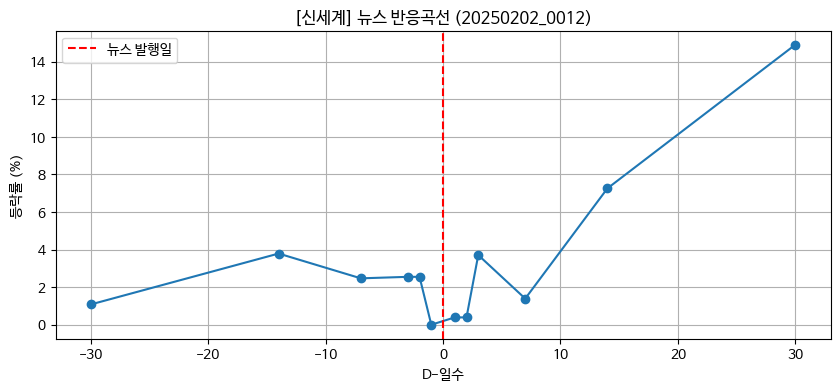

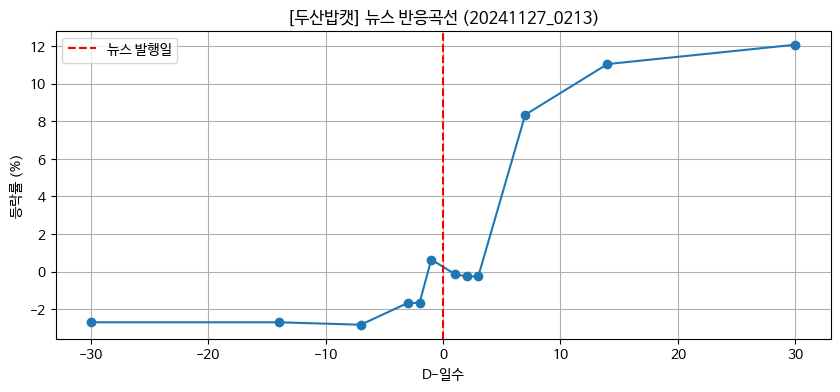

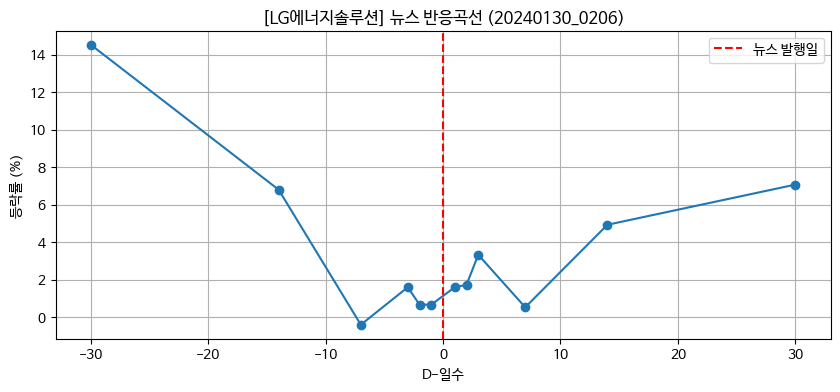

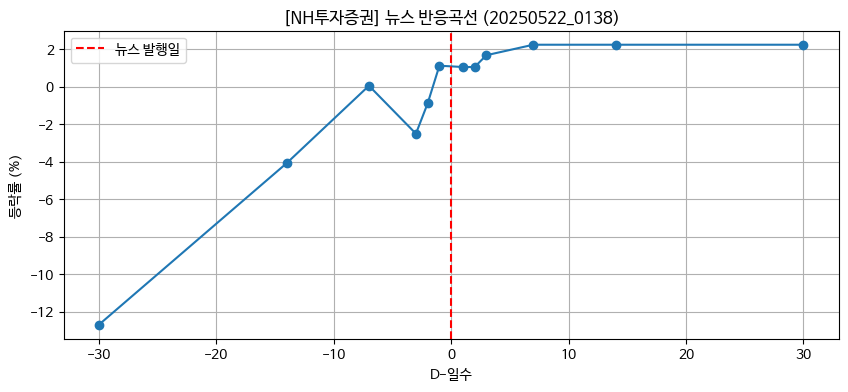

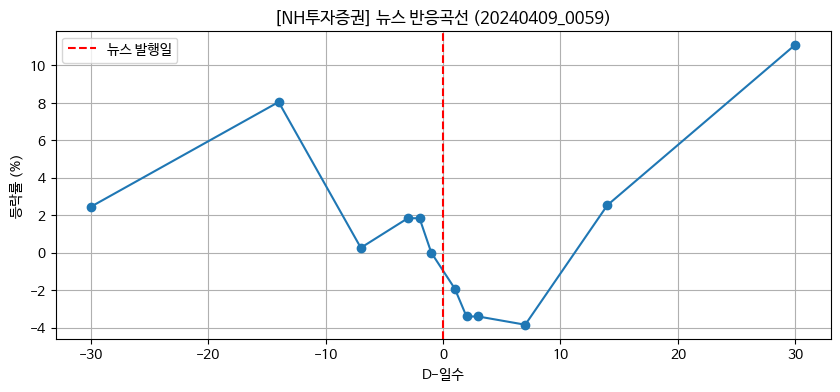

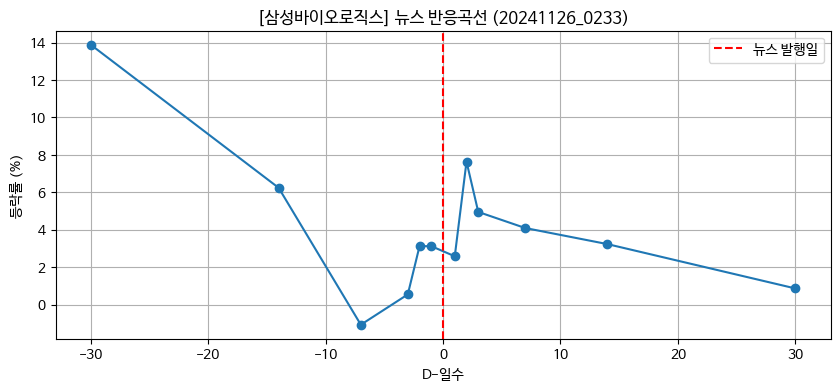

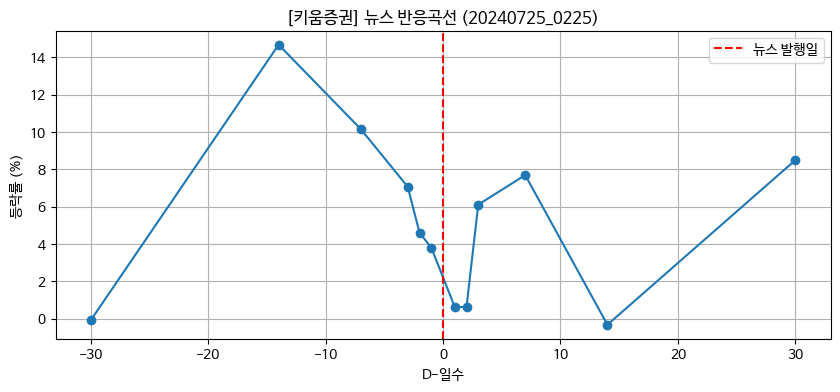

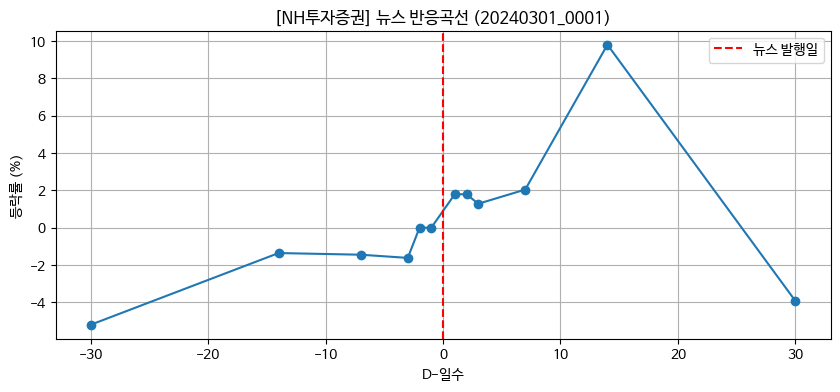

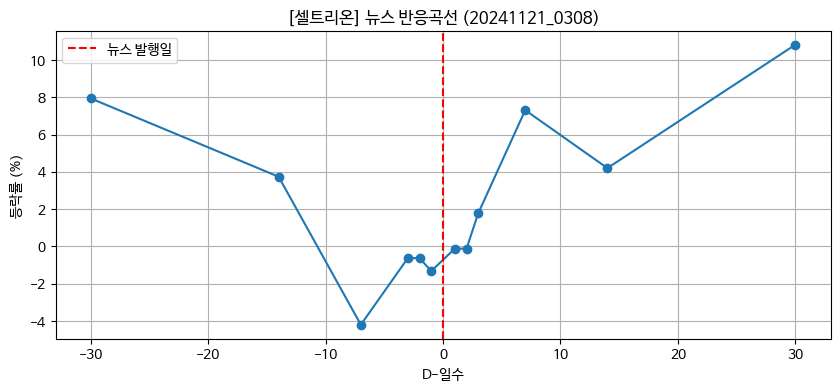

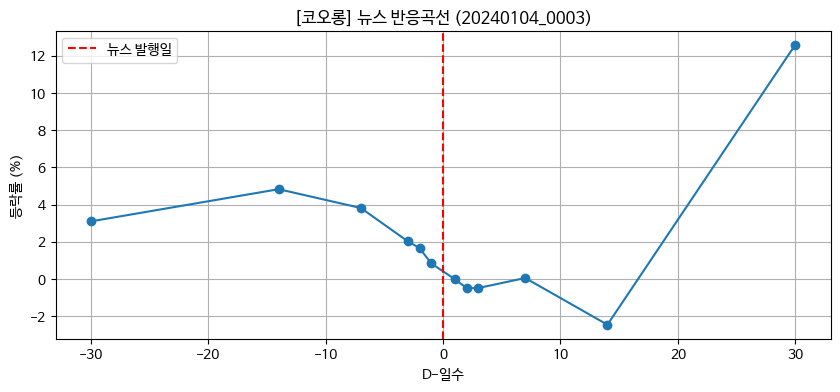

In [40]:
# 사용 예시
for i in range(10):
    plot_one_news(df_combined_bottom_20.iloc[i])

## 데이터셋

In [95]:
df_with_stock_impact = pd.read_csv('news_2023_2025_with_stock_impact.csv')
df_with_stock_impact.head(5)

,news_id,wdate,title,article,press,url,image,text_combined,labels_by_id,stock_name,...,D-3,D-2,D-1,D+1,D+2,D+3,D+7,D+14,D+30,impact_score
0,20250523_0002,2025-05-23 18:52:00,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 후끈",매각가 5000억 안팎 달할듯\n결제시장 내 입지강화 포석\n카카오페이 [사진 = ...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"[단독] 카카오페이, 2500만 회원 쓱·스마일페이 품나…간편결제 시장 빅3 경쟁 ...",['카카오페이'],카카오페이,...,-3.57,-1.62,0.0,4.22,4.22,16.72,26.30,26.30,26.30,30.85
1,20250523_0004,2025-05-23 18:33:00,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다",[사진=연합뉴스]\n세계 2위 투자은행(IB)인 골드만삭스의 사장 겸 최고운영책임자...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,"골드만삭스 차기 CEO, 이재용·김병주·이창용 만났다 [사진=연합뉴스] 세계 2위 ...",['삼성전자'],삼성전자,...,2.77,0.92,0.0,0.92,0.92,-0.55,3.14,3.14,3.14,5.35
2,20250523_0005,2025-05-23 18:24:00,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美,/사진=게티이미지뱅크\n미국 정부가 달러의 기축통화 지위를 위협하는 금에 대응하기 ...,머니투데이,https://n.news.naver.com/mnews/article/008/000...,https://imgnews.pstatic.net/image/008/2025/05/...,흔들리는 미국…달러 패권 붕괴에 '스테이블코인' 선택한 美 /사진=게티이미지뱅크 미...,['상상인증권'],상상인증권,...,2.47,-2.47,0.0,-1.24,-1.24,-4.12,8.66,8.66,8.66,16.70
3,20250523_0007,2025-05-23 18:00:00,[단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진,국내 대표 전자결제사업자인 카카오페이가 신세계이마트 산하 간편결제사업부 인수에 나섰...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://ssl.pstatic.net/static.news/image/news...,[단독] 전자결제 강자 카카오페이 쓱·스마일 페이 인수 추진 국내 대표 전자결제사업...,['카카오페이'],카카오페이,...,-3.57,-1.62,0.0,4.22,4.22,16.72,26.30,26.30,26.30,30.85
4,20250523_0008,2025-05-23 17:58:00,“이 단기 실적 안 좋을 때 사야죠”...비행기 타기 전에 사둔다는 이 주식,큰장 기다리는 韓美 여행주\n시장점유율 1위 부킹홀딩스\n올 최고 유망주 익스피디아...,매일경제,https://n.news.naver.com/mnews/article/009/000...,https://imgnews.pstatic.net/image/009/2025/05/...,“이 단기 실적 안 좋을 때 사야죠”...비행기 타기 전에 사둔다는 이 주식 큰장 ...,"['호텔신라', '하나투어', '아시아나항공', '강원랜드', '대신증권', '대한...",호텔신라,...,-1.35,1.45,0.0,0.52,0.52,1.35,1.14,1.14,1.14,20.72


In [96]:
df_with_stock_impact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35198 entries, 0 to 35197
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   news_id        35198 non-null  object 
 1   wdate          35198 non-null  object 
 2   title          35198 non-null  object 
 3   article        35198 non-null  object 
 4   press          35198 non-null  object 
 5   url            35198 non-null  object 
 6   image          35198 non-null  object 
 7   text_combined  35198 non-null  object 
 8   labels_by_id   35198 non-null  object 
 9   stock_name     35198 non-null  object 
 10  종목코드           35198 non-null  int64  
 11  상장시가총액         35198 non-null  float64
 12  base_price     35198 non-null  float64
 13  D-30           35198 non-null  float64
 14  D-14           35198 non-null  float64
 15  D-7            35198 non-null  float64
 16  D-3            35198 non-null  float64
 17  D-2            35198 non-null  float64
 18  D-1   

## 학습

In [106]:
from transformers import AutoModel, AutoConfig
import torch.nn as nn


class RobertaRegressionHead(nn.Module):
    def __init__(self, model_name="klue/roberta-base"):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.backbone = AutoModel.from_pretrained(model_name)
        self.regressor = nn.Sequential(
            nn.Linear(self.config.hidden_size, 128), nn.ReLU(), nn.Linear(128, 1)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0]
        return self.regressor(cls_output).squeeze(-1)

In [107]:
from transformers import AutoTokenizer
from sklearn.preprocessing import MinMaxScaler
import torch

tokenizer = AutoTokenizer.from_pretrained("klue/roberta-base")
scaler = MinMaxScaler()


def preprocess_data(df):
    # 1. 필요한 컬럼 필터링 및 전처리
    df = df[["text_combined", "impact_score"]].dropna()
    df = df[df["text_combined"].str.len() > 10]
    df = df[df["impact_score"] > 0]

    # 2. 텍스트 토크나이징
    encodings = tokenizer(
        list(df["text_combined"]),
        truncation=True,
        padding="max_length",
        max_length=256,
        return_tensors="pt",
    )

    # 3. impact_score 스케일링 (0~1 정규화)
    scaled_scores = scaler.fit_transform(df[["impact_score"]])
    labels = torch.tensor(scaled_scores.squeeze(), dtype=torch.float)

    return encodings, labels, scaler  # scaler는 나중에 역변환용으로 return

In [ ]:
# 전체 데이터 복사
df_sample = df.copy()

# Train/Val split
df_train, df_val = train_test_split(df_sample, test_size=0.2, random_state=42)

# 전처리 (텍스트 + 수치 피처 + 라벨)
enc_train, x_train_num, y_train = preprocess_data(df_train, fit_scaler=True)
enc_val, x_val_num, y_val = preprocess_data(df_val, fit_scaler=False)


# 새로운 Dataset 클래스 필요
class NewsImpactWithNumericalDataset(Dataset):
    def __init__(self, encodings, numerical_feats, labels):
        self.encodings = encodings
        self.numerical_feats = numerical_feats
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["tabular_feats"] = self.numerical_feats[idx]
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


# Dataset 구성
train_dataset = NewsImpactWithNumericalDataset(enc_train, x_train_num, y_train)
val_dataset = NewsImpactWithNumericalDataset(enc_val, x_val_num, y_val)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [112]:
train_losses = []

epochs = 5

for epoch in range(epochs):
    total_loss = 0
    model.train()
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

Epoch 1:   3%|▎         | 10/375 [00:52<31:55,  5.25s/it]


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("학습 손실 (Loss) 추이")
plt.grid(True)
plt.show()

In [ ]:
torch.save(model.state_dict(), "roberta_impact_regression.pt")

## 모델 평가

In [ ]:
model.load_state_dict(torch.load("roberta_impact_regression.pt"))
model.eval()
predict_impact("삼성전자가 실적 발표를 했다", model, tokenizer)

Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


: 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"]
            attention_mask = batch["attention_mask"]
            labels = batch["labels"]

            preds = model(input_ids, attention_mask)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    mae = mean_absolute_error(all_labels, all_preds)
    rmse = mean_squared_error(all_labels, all_preds, squared=False)
    r2 = r2_score(all_labels, all_preds)

    print(f"✅ MAE:  {mae:.3f}")
    print(f"✅ RMSE: {rmse:.3f}")
    print(f"✅ R²:   {r2:.3f}")

    return all_labels, all_preds